In [1]:
# General
import os
from tqdm import tqdm
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 7)  # make the default figure size larger
matplotlib.rcParams['image.interpolation'] = 'nearest'  # don't blur/smooth image plots
from astropy.io import fits
from astropy.table import Table

# Apodizing function
from scipy.signal import get_window

# Pysynphot
import pysynphot as S

# Grizli
import grizli
from grizli.model import GrismFLT

# Webbpsf
import webbpsf
import webbpsf.roman

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/6) predictable_extract/fits")

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
# Calculate PSFs at all wavelengths
wfi = webbpsf.roman.WFI()
webbpsf.setup_logging(level="ERROR")
src = webbpsf.specFromSpectralType('G0V', catalog='phoenix')
wave_range = np.linspace(10000, 20000, 5)

wave_dependent = {}

for ii in tqdm(wave_range):
    wave_dependent[ii] = wfi.calc_psf(monochromatic=(ii*(10**-10)), fov_pixels=182, oversample=2, source=src)

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


In [3]:
pad = 0
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None)
empty_direct.fits / Pad ref HDU with 64 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [4]:
# G0V Spectrum source file
src = webbpsf.specFromSpectralType('G0V', catalog='phoenix')
wave = np.linspace(10000,20000,10001) # Angstroms
flux = src(wave).value
star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam")
del wave
del flux

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

star_spec = star_spec.renorm(13, "abmag", bp)
star_spec.convert("flam")

In [5]:
# Wavelength dependent PSF
full_model = np.zeros((4088,4088))

for start_wave in tqdm(wave_range[0:-1]):

    temp_dir = np.zeros((4088,4088))
    temp_seg = np.zeros((4088,4088))

    temp_dir[1862:2226, 1862:2226] = wave_dependent[start_wave][0].data
    
    condition = temp_dir[1862:2226, 1862:2226] != 0
    temp_seg[1862:2226, 1862:2226][np.where(condition)] = 1

    roman.direct.data["SCI"] = temp_dir.astype("float32")
    roman.seg = temp_seg.astype("float32")

    next_index = np.where(wave_range == start_wave)[0] + 1
    end_wave = wave_range[next_index]

    start_index = int(start_wave - 10000)
    end_index = int(end_wave - 10000)

    # Window config
    # size in number of points; window_wave_extent is how many angstroms the window spans
    size = int(10)
    half_size = int(size / 2)
    window_wave_extent = 100
    half_extent = int(window_wave_extent / 2)

    front_window_wave = np.linspace(-np.pi, 0, half_size)
    back_window_wave = np.linspace(0, np.pi, half_size)
    front_flux = 0.5 * (np.cos(front_window_wave) + 1)
    back_flux = 0.5 * (np.cos(back_window_wave) + 1)

    # Cutout wavelength
    cutout_wave = star_spec.wave[start_index:end_index]
    # front = np.linspace(cutout_wave[half_extent] - half_extent, cutout_wave[half_extent], half_size, endpoint=False)
    # back = np.linspace(cutout_wave[-half_extent + 1], cutout_wave[-half_extent + 1] + half_extent, half_size, endpoint=False)
    # cutout_wave = np.append(front, np.append(cutout_wave, back))

    # Cutout & window flux
    cutout_flux = star_spec.flux[start_index:end_index]
    
    # front_flux *= cutout_flux[:half_size]
    # back_flux *= cutout_flux[-half_size:]
    # cutout_flux = np.append(np.append(front_flux, cutout_flux), back_flux)

    model = roman.compute_model_orders(id=1, mag=13, compute_size=False, size=77,
                                                 in_place=False, store=False, 
                                                 spectrum_1d=[cutout_wave, cutout_flux], 
                                                 is_cgs=True)

    if type(model) is bool:
        bool_iis.append(ii)

    if type(model) is not bool:
        full_model += model[1]

  0%|          | 0/4 [00:00<?, ?it/s][py.warnings] /var/folders/r6/mx60w78n6_dfz54ll0pj9vf00000gn/T/ipykernel_5008/3851442416.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_index = int(end_wave - 10000)

100%|██████████| 4/4 [00:00<00:00, 17.61it/s]


In [6]:
# Single PSF
single_PSF_model = roman.compute_model_orders(id=1, mag=13, compute_size=False, size=100,
                                              in_place=False, store=False, is_cgs=True,
                                              spectrum_1d=[star_spec.wave, star_spec.flux])

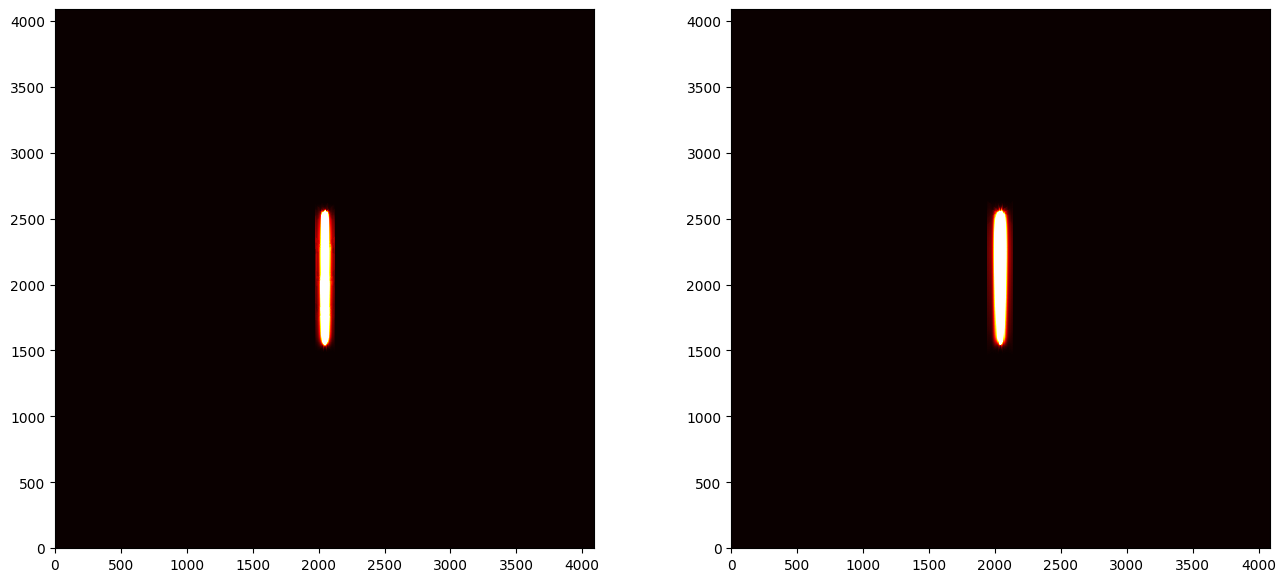

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)

upright_wave_dep = np.rot90(full_model)
ax1.imshow(upright_wave_dep, origin='lower', interpolation='nearest', vmin=0, vmax=0.20, cmap='hot')

upright_one_psf = np.rot90(single_PSF_model[1])
ax2.imshow(upright_one_psf, origin='lower', interpolation='nearest', vmin=0, vmax=0.20, cmap='hot')

In [8]:
# Comparing extraction methods and results
fluxes_max_wave_dep = []
fluxes_sum_wave_dep = []
fluxes_max_one_psf = []
fluxes_sum_one_psf = []

for ii in reversed(range(2044-501, 2044+500)):
    fluxes_max_wave_dep.append(upright_wave_dep[ii, :].max())
    fluxes_sum_wave_dep.append(upright_wave_dep[ii, :].sum())
    fluxes_max_one_psf.append(upright_one_psf[ii, :].max())
    fluxes_sum_one_psf.append(upright_one_psf[ii, :].sum())

Text(0.5, 1.0, 'Spectrum Extractions')

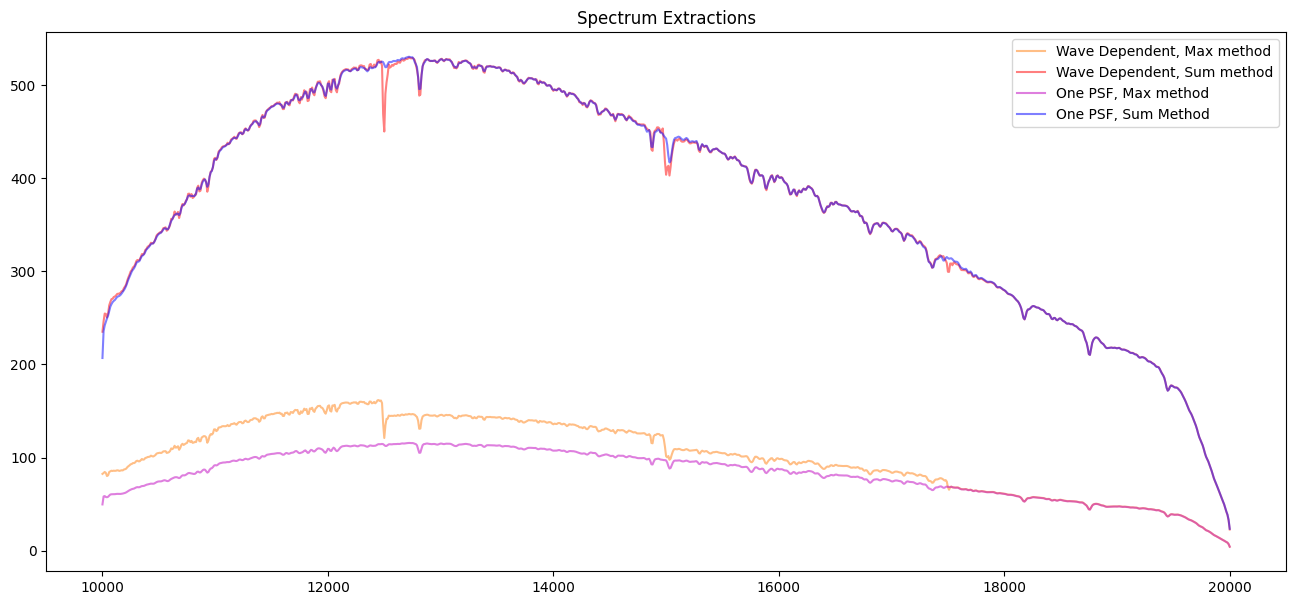

In [9]:
x = np.linspace(10000, 20001, 1001)
plt.plot(x, fluxes_max_wave_dep, c='tab:orange', alpha=0.5, label="Wave Dependent, Max method")
plt.plot(x, fluxes_sum_wave_dep, c='r', alpha=0.5, label="Wave Dependent, Sum method")
plt.plot(x, fluxes_max_one_psf, c='m', alpha=0.5, label="One PSF, Max method")
plt.plot(x, fluxes_sum_one_psf, c='b', alpha=0.5, label="One PSF, Sum Method")

plt.legend()
plt.title("Spectrum Extractions")